<a href="https://colab.research.google.com/github/Khushm/SRIP-IITGN-2022/blob/main/Neural%20Network%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing the required jax numpy library for calculations
import jax.tools.colab_tpu
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import numpy as np
import jax
from jax import jit, vmap, pmap, grad, value_and_grad, random

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# importing matplotlib for visualization
import matplotlib.pyplot as plt

## Hyperparameters

In [ ]:
layer_sizes = [784, 512, 512, 10]
step_size = 0.01
num_epochs = 10
batch_size = 128
n_targets = 10
mnist_img_size = (28, 28)

seed = 0
key = jax.random.PRNGKey(seed)

In [2]:
# Function to initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(layer_sizes, key, step_size):
  params = []
  keys = random.split(key, num=len(layer_sizes)-1)
  
  # loop to randomly initialize weights and biases
  # for a dense neural network layer
  for in_width, out_width, key in zip(layer_sizes[:-1], layer_sizes[1:], keys):
    weight_key, bias_key = jax.random.split(key)
    params.append([
          step_size * jax.random.normal(weight_key, shape=(out_width, in_width)),
          step_size * jax.random.normal(bias_key, shape=(out_width,))
          ])
  return params


params = init_network_params(layer_sizes, key, step_size)
print(jax.tree_map(lambda x: x.shape, params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


In [4]:
def relu(x):
  return jnp.maximum(0, x)


def predict(params, image):
   hidden_layers = params[:-1]

   activations = image
   for w, b in hidden_layers:
     outputs = jnp.dot(w, activations) + b
     activations = relu(outputs)

   final_w, final_b = params[-1]
   logits = jnp.dot(final_w, activations) + final_b
   return logits - logsumexp(logits) 


x = np.random.randn(np.prod(mnist_img_size))
random_flattened_images = np.random.randn(16, jnp.prod(mnist_img_size))

# use JAX’s vmap function to automatically handle mini-batches, 
# with no performance penalty
batched_predict = vmap(predict, in_axes=(None,0))
predictions = batched_predict(params, random_flattened_images)
print(predictions.shape)

(784,)
(10,)
(16, 784)
(16, 10)


At this point, we have all the ingredients we need to define our neural network and train it. 

## Data Loading

In [5]:
def custom_transform(x):
    return jnp.ravel(jnp.array(x, dtype=jnp.float32))

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = jnp.array(transposed_data[1])
    imgs = jnp.stack(transposed_data[0])

    return imgs, labels


train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/train-images-idx3-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/train-images-idx3-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to test_mnist/MNIST/raw

(128, 784) float32 (128,) int32


## Utility and loss functions

0.23620136
0.09331226
0.061165657
0.061554816
0.048409738
0.0375039
0.034083482
0.03638419
0.03326985
0.037487634
Epoch 0, train acc = 0.914566695690155 test acc = 0.91839998960495
0.038405858
0.024046522
0.018745877
0.028058542
0.015707094
0.021226227
0.021766996
0.021291586
0.02214129
0.02709255
Epoch 1, train acc = 0.933566689491272 test acc = 0.9330999851226807
0.015601185
0.018695123
0.015288181
0.028290648
0.014652199
0.01607419
0.020326218
0.025600908
0.015200118
0.02048488
Epoch 2, train acc = 0.9468333721160889 test acc = 0.9438999891281128
0.016418014
0.017994097
0.0187169
0.015114881
0.015546544
0.010509
0.015882265
0.015555218
0.02056253
0.020154018
Epoch 3, train acc = 0.9547500014305115 test acc = 0.9512999653816223
0.022642586
0.018819252
0.015796745
0.0176509
0.0097110085
0.008230402
0.02801398
0.013505689
0.015983572
0.0073100417
Epoch 4, train acc = 0.9598166942596436 test acc = 0.9557999968528748
0.015866939
0.017593712
0.009598013
0.01472216
0.019702727
0.010664845


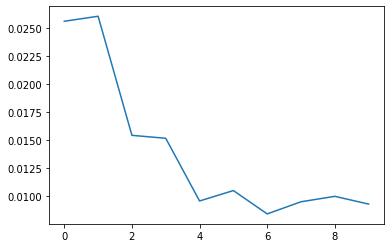

In [6]:
def loss(params, images, gt_lbls):
    predictions = batched_predict(params, images)
    return -jnp.mean(predictions * gt_lbls)


def accuracy(params, images, dataset_lbls):
    target_class = jnp.argmax(dataset_lbls, axis=1)
    predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
    return jnp.mean(predicted_class == target_class)

# use jit to speed up everything
@jit
def update(params, images, gt_lbls, lr=step_size):
    # use grad to take the derivative of the loss 
    # with respect to the neural network parameters
    loss_value, grads = value_and_grad(loss)(params, images, gt_lbls)
    return loss_value, jax.tree_multimap(lambda p, g: p - lr*g, params, grads)

# Create a MLP
params = init_network_params([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

loss_values = []
for epoch in range(num_epochs):
    for cnt, (imgs, lbls) in enumerate(train_loader):
        gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes))
        loss, MLP_params = update(params, imgs, gt_labels)    
    loss_values.append(loss)
    print(f'Epoch {epoch}, train acc = {accuracy(params, train_images, train_lbls)} test acc = {accuracy(params, test_images, test_lbls)}')
    print(f'Epoch {epoch}, train acc = {loss(params, train_images, train_lbls)} test acc = {loss(params, test_images, test_lbls)}')
plt.plot(loss_values)
plt.show()

(28, 28)
pred 9
gt 9


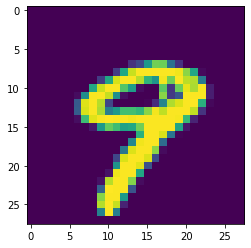

In [7]:
imgs, lbls = next(iter(test_loader))
img = imgs[9].reshape(mnist_img_size)
gt_lbl = lbls[9]
print(img.shape)


pred = jnp.argmax(predict(params, np.ravel(img)))
print('prediction: ', pred)
print('actual: ', gt_lbl)

plt.imshow(img); plt.show()

## Conclusion
We’ve used the whole of the JAX API: grad for derivatives, jit for speedups and vmap for auto-vectorization. We used NumPy to specify all of our computation, and borrowed the great data loaders from torch/datasets.